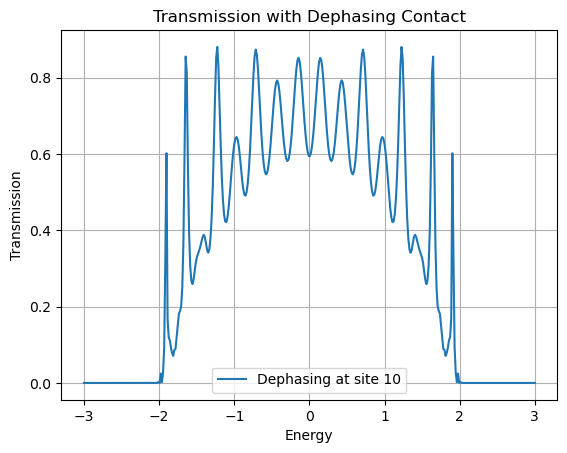

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS
# -----------------------------
N = 20               # number of sites
t = 1.0              # hopping energy
eps = 0.0            # on-site energy
eta = 1e-5           # small imaginary for causality
deph_site = 10       # site where dephasing happens
d_strength = 0.5     # dephasing strength
energy_range = np.linspace(-3, 3, 400)

# -----------------------------
# HAMILTONIAN
# -----------------------------
H = np.zeros((N, N), dtype=complex)
for i in range(N):
    H[i, i] = eps
    if i < N - 1:
        H[i, i + 1] = H[i + 1, i] = -t

# -----------------------------
# SELF-ENERGIES (Wide Band)
# -----------------------------
Gamma_L = np.zeros((N, N), dtype=complex)
Gamma_L[0, 0] = 1.0

Gamma_R = np.zeros((N, N), dtype=complex)
Gamma_R[-1, -1] = 1.0

Sigma_L = -0.5j * Gamma_L
Sigma_R = -0.5j * Gamma_R

# -----------------------------
# DEPHASING LOOP
# -----------------------------
T_arr = []
for E in energy_range:
    # Initial guess for dephasing self-energy
    Sigma_d = np.zeros((N, N), dtype=complex)

    for _ in range(10):  # Iterate to self-consistency
        G = np.linalg.inv((E + 1j * eta) * np.eye(N) - H - Sigma_L - Sigma_R - Sigma_d)
        G_dd = G[deph_site, deph_site]
        Sigma_d[deph_site, deph_site] = d_strength ** 2 * G_dd

    # Recompute G with final Sigma_d
    G = np.linalg.inv((E + 1j * eta) * np.eye(N) - H - Sigma_L - Sigma_R - Sigma_d)

    # Gamma matrices
    Gamma_d = 1j * (Sigma_d - Sigma_d.conj().T)

    # Transmission from L to R (Datta-style)
    T = np.real(np.trace(Gamma_L @ G @ Gamma_R @ G.conj().T))
    T_arr.append(T)

# -----------------------------
# PLOT
# -----------------------------
plt.plot(energy_range, T_arr, label=f'Dephasing at site {deph_site}')
plt.xlabel("Energy")
plt.ylabel("Transmission")
plt.title("Transmission with Dephasing Contact")
plt.grid(True)
plt.legend()
plt.show()


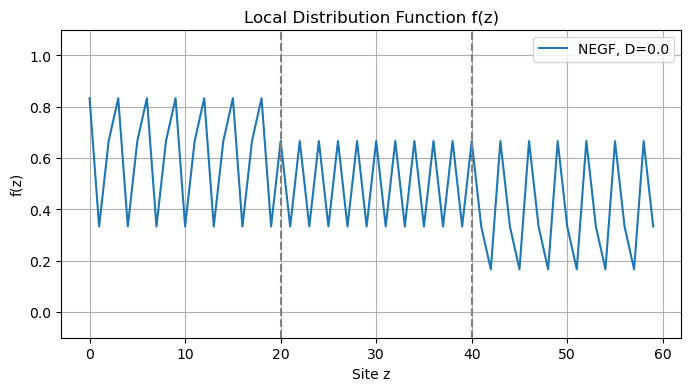

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 60          # number of sites
t0 = 1.0        # hopping
U0 = t0         # barrier height
eta = 1e-5
E = t0          # energy at which f(z) is computed
dephasing_strength = 0.0  # set to >0.0 to simulate red curve

# Build Hamiltonian with a barrier in the center
H = np.zeros((N, N), dtype=complex)
for i in range(N):
    H[i, i] = 0
    if 20 <= i <= 40:  # central barrier region
        H[i, i] += U0
    if i < N - 1:
        H[i, i+1] = H[i+1, i] = -t0

# Wide-band Gamma matrices
Gamma_L = np.zeros((N, N), dtype=complex)
Gamma_R = np.zeros((N, N), dtype=complex)
Gamma_L[0, 0] = 2 * t0
Gamma_R[-1, -1] = 2 * t0
Sigma_L = -0.5j * Gamma_L
Sigma_R = -0.5j * Gamma_R

# Fermi functions
fL = 1.0
fR = 0.0

# Initialize dephasing self-energy
Sigma_d = np.zeros((N, N), dtype=complex)

# Self-consistent dephasing
for _ in range(10):
    G = np.linalg.inv((E + 1j * eta) * np.eye(N) - H - Sigma_L - Sigma_R - Sigma_d)
    G_d = np.diag(G)
    for i in range(N):
        Sigma_d[i, i] = (dephasing_strength ** 2) * G_d[i]

# Final Green's function
G = np.linalg.inv((E + 1j * eta) * np.eye(N) - H - Sigma_L - Sigma_R - Sigma_d)

# Broadening matrices
Gamma_d = 1j * (Sigma_d - Sigma_d.conj().T)

# In-scattering self-energies
Sigma_in = fL * Gamma_L + fR * Gamma_R + 0.5 * Gamma_d
G_n = G @ Sigma_in @ G.conj().T

# Local spectral function A = i(G - G†)
A = 1j * (G - G.conj().T)

# Local occupation f(z) = iG^n / A
f_z = np.real(np.diag(G_n)) / (np.real(np.diag(A)) + 1e-20)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(f_z, label=f"NEGF, D={dephasing_strength}")
plt.axvline(20, color='gray', linestyle='--')
plt.axvline(40, color='gray', linestyle='--')
plt.xlabel("Site z")
plt.ylabel("f(z)")
plt.title("Local Distribution Function f(z)")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()
plt.show()
